In [ ]:
#ディリクレ過程を使ったクラスタリングの基本プログラム
#2021年1月23日からリアルデータに拡張して作成

In [1]:
from __future__ import print_function
import argparse
import torch
from torch.utils import data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

import pandas as pd
import GPy
from scipy.io import loadmat
import scipy.io as spio

%matplotlib inline
import matplotlib.pyplot as plt
from torch.distributions.multivariate_normal import MultivariateNormal
import numpy as np


from sklearn.manifold import TSNE
from random import random
from sklearn.mixture import GaussianMixture
from sklearn.mixture import BayesianGaussianMixture
from sklearn.cluster import KMeans

import math

import os
from PIL import Image
import torch.nn as nn
import torchvision.models as models
from torch.autograd import Variable


import glob
import torchvision.transforms as transforms
import torchvision
from sklearn.model_selection import train_test_split
import pickle
import copy

In [2]:
X_p_l10 = np.load('../../MNIST/VAE/clustering-during-VAE/gmm-resnet-results/data/mus_g_N10000_L10_ep150_bs50_res101.npy')
ts_p_l10 = np.load('../../MNIST/VAE/clustering-during-VAE/gmm-resnet-results/data/ts_g_N10000_L10_ep150_bs50_res101.npy')
initial_data_dim = X_p_l10.shape[1]


#X_p_l10 = np.load('../../MNIST/VAE/clustering-during-VAE/gmm-resnet-results/data/mus_g_N10000_L10_ep150_bs50_beta192.0_res101.npy')
#ts_p_l10 = np.load('../../MNIST/VAE/clustering-during-VAE/gmm-resnet-results/data/ts_g_N10000_L10_ep150_bs50_beta192.0_res101.npy')
#initial_data_dim = X_p_l10.shape[1]


real_cluster_number = 10
N_data_one_cluster =100

In [744]:
#X_p_l5 = np.load('../../MNIST/VAE/clustering-during-VAE/gmm-resnet-results/data/mus_g_N10000_L5_ep150_bs50_res101.npy')
#ts_p_l5 = np.load('../../MNIST/VAE/clustering-during-VAE/gmm-resnet-results/data/ts_g_N10000_ep150_bs50_res101.npy')
#initial_data_dim = X_p_l10.shape[1]
N_sample = 2000
X_2d_p_data = X_p_l10.squeeze()[0:N_sample]
ts_p_data = ts_p_l10[0:N_sample]

In [745]:
X_2d_p_data.shape,ts_p_data.shape


((2000, 10), (2000,))

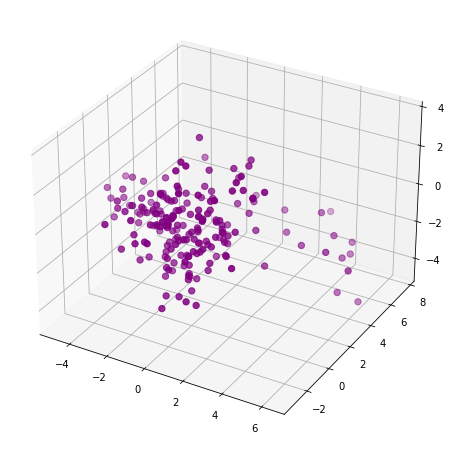

In [746]:
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_2d_p_data[:200,0], X_2d_p_data[:200,1], X_2d_p_data[:200,2], s = 40, c = "purple")
plt.show()

Widget Javascript not detected.  It may not be installed or enabled properly.


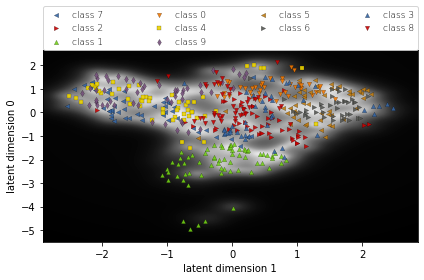

In [16]:
normalized_observed_data = (X_2d_p_data-X_2d_p_data.mean(axis=0))/X_2d_p_data.std(axis=0)
input_dim =3
kernel = GPy.kern.RBF(input_dim, ARD=True) + GPy.kern.Bias(input_dim) + GPy.kern.Linear(input_dim) + GPy.kern.White(input_dim)
model = GPy.models.GPLVM(normalized_observed_data, input_dim=input_dim,kernel=kernel)
model.optimize(messages=True, max_iters=1e3)
model.plot_latent(labels=ts_p_data)
plt.savefig("output/gplvm.png")

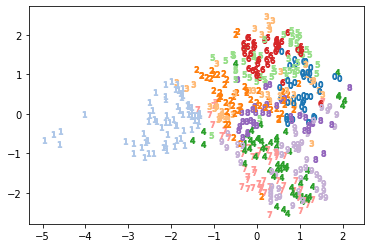

In [17]:
model.X.shape
cm = plt.cm.get_cmap('tab20')
for p,l in zip(model.X,ts_p_data):
    plt.scatter(p[0],p[1],marker="${}$".format(l),color=cm.colors[l])

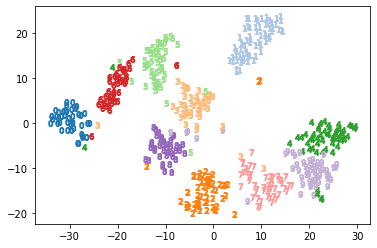

In [15]:
points = TSNE(n_components=2,random_state=0).fit_transform(X_2d_p_data)
for p,l in zip(points,ts_p_data):
    plt.scatter(p[0],p[1],marker="${}$".format(l),color=cm.colors[l])

In [18]:
def log_P_func(l_f,latent_data_f,pick_up_number_f,dirichlet_alpha_f,pre_nu_f,pre_beta_f,pre_mu_0_f,S_0_inv_f):

    cluster_data = latent_data_f[l_f]
    cluster_center = cluster_data.mean(axis=0)
    n_prime = len(l_f)
    mu_c = (n_prime*cluster_center+pre_beta_f*pre_mu_0_f)/(n_prime+pre_beta_f)
#    mu_c = n_prime*cluster_center
#    mu_c +=pre_beta_f*pre_mu_0_f
#    mu_c/=(n_prime+pre_beta_f)

    S_q_inv = S_0_inv_f + n_prime*np.cov(cluster_data,rowvar=0,bias=1) + n_prime*pre_beta_f*np.outer(cluster_center-pre_mu_0_f,cluster_center-pre_mu_0_f)/(n_prime + pre_beta_f)
    S_r_inv = S_q_inv + (n_prime + pre_beta_f)*np.outer(latent_data_f[pick_up_number_f]-mu_c,latent_data_f[pick_up_number_f]-mu_c)/(n_prime + pre_beta_f+1)
    data_dim = latent_data_f[pick_up_number_f].shape[0]
    n_total = latent_data_f.shape[0]
#    print("n_prime={}".format(n_prime))
#    print("cluster_center={}".format(cluster_center))
#    print("mu_c={}".format(mu_c))
#    print("S_q_inv={}".format(S_q_inv))
#    print("S_r_inv={}".format(S_r_inv))
#    print("data_dim={}".format(data_dim))
#    print("n_total={}".format(n_total))

#    return S_r_inv,S_q_inv
#    return np.log(n_prime/(n_total-1+dirichlet_alpha_f))+0.5*data_dim*np.log((n_prime+pre_beta_f)/(n_prime+pre_beta_f+1)/math.pi) - 0.5*(pre_nu_f + n_prime +1)*np.log(S_r_inv)+0.5*(pre_nu_f + n_prime)*np.log(S_q_inv)+math.lgamma(0.5*(pre_nu_f+n_prime+1))-math.lgamma(0.5*(pre_nu_f+n_prime+1-data_dim))
    return np.log(n_prime/(n_total-1+dirichlet_alpha_f))+0.5*data_dim*np.log((n_prime+pre_beta_f)/(n_prime+pre_beta_f+1)/math.pi) - 0.5*(pre_nu_f + n_prime +1)*np.log(np.linalg.det(S_r_inv))+0.5*(pre_nu_f + n_prime)*np.log(np.linalg.det(S_q_inv))+math.lgamma(0.5*(pre_nu_f+n_prime+1))-math.lgamma(0.5*(pre_nu_f+n_prime+1-data_dim))


def log_P_new_func(latent_data_f,pick_up_number_f,dirichlet_alpha_f,pre_nu_f,pre_beta_f,pre_mu_0_f,S_0_inv_f):

    picked_data = latent_data_f[pick_up_number_f]
    S_b_inv = S_0_inv_f + pre_beta_f*np.outer(picked_data-pre_mu_0_f,picked_data-pre_mu_0_f)/(pre_beta_f+1)
    data_dim = picked_data.shape[0]
    n_total = latent_data_f.shape[0]

#    print("S_0_inv={}".format(S_0_inv_f))
#    print("S_b_inv={}".format(S_b_inv))
#    print("data_dim={}".format(data_dim))
#    print("n_total={}".format(n_total))

    return np.log(dirichlet_alpha_f/(n_total-1+dirichlet_alpha_f))+0.5*data_dim*np.log(pre_beta_f/(pre_beta_f+1)/math.pi) - 0.5*(pre_nu_f + 1)*np.log(np.linalg.det(S_b_inv))+0.5*pre_nu_f*np.log(np.linalg.det(S_0_inv_f))+math.lgamma(0.5*(pre_nu_f+1))-math.lgamma(0.5*(pre_nu_f+1-data_dim))
#    return np.log(dirichlet_alpha_f/(n_total-1+dirichlet_alpha_f))+0.5*data_dim*np.log(pre_beta_f/(pre_beta_f+1)/math.pi) - 0.5*(pre_nu_f + 1)*np.log(S_b_inv)+0.5*pre_nu_f*np.log(S_0_inv_f)+math.lgamma(0.5*(pre_nu_f+1))-math.lgamma(0.5*(pre_nu_f+1-data_dim))

In [19]:
def sum_del_log_gamma(nu,n,dim):
    x=0
    for i in range(dim):
       x+= math.lgamma(0.5*(nu+n-i))-math.lgamma(0.5*(nu-i))
    return x

def log_P_total(list_list,latent_data,dirichlet_alpha,pre_nu,pre_beta,pre_mu_0,S_0_inv):

    cluster_number = len(list_list)
    data_dim = latent_data[0].shape[0]
    n_total = latent_data.shape[0]

    log_P = cluster_number*np.log(dirichlet_alpha)-math.lgamma(dirichlet_alpha+n_total)+ math.lgamma(dirichlet_alpha)
    for l in list_list:
        number_in_cluster = len(l)
        data_l = latent_data[l]
        data_l_av = data_l.mean(axis=0)
        S_q_inv = S_0_inv + number_in_cluster*np.cov(data_l,rowvar=0,bias=1)+ number_in_cluster*pre_beta*np.outer(data_l_av-pre_mu_0,data_l_av-pre_mu_0)/(number_in_cluster+pre_beta)
#        log_P += math.lgamma(number_in_cluster) -0.5*(pre_nu+number_in_cluster)*np.log(S_q_inv) +0.5*pre_nu*np.log(S_0_inv)+sum_del_log_gamma(pre_nu,number_in_cluster,data_dim)+0.5*data_dim*(np.log(pre_beta/(number_in_cluster+pre_beta))-number_in_cluster*np.log(math.pi))
        log_P += math.lgamma(number_in_cluster) -0.5*(pre_nu+number_in_cluster)*np.log(np.linalg.det(S_q_inv)) +0.5*pre_nu*np.log(np.linalg.det(S_0_inv))+sum_del_log_gamma(pre_nu,number_in_cluster,data_dim)+0.5*data_dim*(np.log(pre_beta/(number_in_cluster+pre_beta))-number_in_cluster*np.log(math.pi))

    return log_P

In [20]:
def softmax(a):
    # 一番大きい値を取得
    c = np.max(a)
    # 各要素から一番大きな値を引く（オーバーフロー対策）
    exp_a = np.exp(a - c)
    sum_exp_a = np.sum(exp_a)
    # 要素の値/全体の要素の合計
    y = exp_a / sum_exp_a
    return y

In [21]:
def cluster_prob(list_list,latent_data,pick_up_number,dirichlet_alpha,pre_nu,pre_beta,pre_mu_0,S_0_inv):

    for l in list_list:
        if pick_up_number in l:
            current_place = list_list.index(l)
            list_list[current_place].remove(pick_up_number)

    for x in list_list:
        if x == []:
#            disappearing_index = list_list.index(x)
            list_list.remove(x)

    log_P = np.empty(len(list_list)+1)
    for i, l in enumerate(list_list):
        log_P[i] = log_P_func(l,latent_data,pick_up_number,dirichlet_alpha,pre_nu,pre_beta,pre_mu_0,S_0_inv)

    log_P[len(list_list)] = log_P_new_func(latent_data,pick_up_number,dirichlet_alpha,pre_nu,pre_beta,pre_mu_0,S_0_inv)

    return softmax(log_P)

In [22]:
def show_mean_cov(X_data,list_list):

    N_cluster = len(list_list)
    for i in range(N_cluster):
        X_0 = X_data[list_list[i]]
        print("--cluster{}--".format(i))
        print("N_member_{}={}".format(i,len(list_list[i])))
        print("Mean_{}={}".format(i,X_0.mean(axis=0)))
        print("Cov_{}=\n{}\n".format(i,np.cov(X_0,rowvar=0,bias=1)))


In [23]:
cm = plt.cm.get_cmap('tab20')
def drawpoints_with_centers(mus_numpy,ts_numpy,list_list):
    for p,l in zip(mus_numpy,ts_numpy):
        plt.scatter(p[0],p[1],marker="${}$".format(l),color=cm.colors[l])

    N_cluster = len(list_list)
    X_mean = np.empty([N_cluster,2])
    for i in range(N_cluster):
        X_mean[i] = mus_numpy[list_list[i]].mean(axis=0)
    for p in X_mean:
        plt.scatter(p[0],p[1],facecolors='none',edgecolors='red',s=200)
    for i, p in enumerate(X_mean):
        plt.scatter(p[0],p[1],marker="${}$".format(i),color='black',s=50)
    plt.show()

In [24]:
cm = plt.cm.get_cmap('tab20')
def drawpoints_3d(mus_numpy,ts_numpy):
    fig = plt.figure(figsize = (8, 8))
    ax = fig.add_subplot(111, projection='3d')
#    for i in range(len(list_list)):
#        ax.scatter(mus_numpy[list_list[i],0], mus_numpy[list_list[i],1], mus_numpy[list_list[i],2], s = 40, color=cm.colors[i])
    for p,l in zip(mus_numpy,ts_numpy):
        ax.scatter(p[0],p[1],marker="${}$".format(l),color=cm.colors[l])

    plt.show()

In [25]:
def clustering_index(list_list):

    total_N =0
    for l in list_list:
        total_N += len(l)

    ts = np.empty(total_N)
    for i, l in enumerate(list_list):
        ts[l] = i

    return ts.astype(int)

In [26]:
def one_epoch(list_list,X_data,dirichlet_alpha,pre_nu,pre_beta,pre_mu_0,S_0_inv):
    for pick_up_index in range(X_data.shape[0]):
        probability = cluster_prob(list_list,X_data,pick_up_index,dirichlet_alpha,pre_nu,pre_beta,pre_mu_0,S_0_inv)
        selected_cluster = np.random.choice(a=np.arange(len(list_list)+1),size=1,p=probability).item()
        if selected_cluster == len(list_list):
            list_list.append([pick_up_index])
        else:
            list_list[selected_cluster].append(pick_up_index)

In [27]:
def clustering(epoch_max,stopping_epoch,list_list,X_data,dirichlet_alpha,pre_nu,pre_beta,pre_mu_0,S_0_inv):

    best_log_P = log_P_total(list_list,X_data,dirichlet_alpha,pre_nu,pre_beta,pre_mu_0,S_0_inv)
    best_list_list =  copy.deepcopy(list_list)
    k=0
    for i in range(epoch_max):
        one_epoch(list_list,X_data,dirichlet_alpha,pre_nu,pre_beta,pre_mu_0,S_0_inv)
        print("i={},k={},N_cluster={},clustering_numbers = {}".format(i,k,len(list_list),[len(l) for l in list_list]))
        k+=1
        if log_P_total(list_list,X_data,dirichlet_alpha,pre_nu,pre_beta,pre_mu_0,S_0_inv) > best_log_P:
            best_log_P=log_P_total(list_list,X_data,dirichlet_alpha,pre_nu,pre_beta,pre_mu_0,S_0_inv)
            best_list_list =  copy.deepcopy(list_list)
            print("best value is updated. best_log_p={},N_cluster={}".format(best_log_P,len(best_list_list)))
            k=0
        if k == stopping_epoch:
            break

    return best_log_P,best_list_list,i




In [841]:
normalized_observed_data = (X_2d_p_data-X_2d_p_data.mean(axis=0))/X_2d_p_data.std(axis=0)
#points = TSNE(n_components=2,random_state=0,perplexity=30,early_exaggeration=12,learning_rate=200,init='random',method='barnes_hut',angle=0.2).fit_transform(X_2d_p_data)
points = TSNE(n_components=2,random_state=0,perplexity=30,early_exaggeration=12,learning_rate=200,init='random',method='barnes_hut',angle=0.2).fit_transform(normalized_observed_data)
dirichlet_alpha_g = 1.
pre_nu_g =10.
pre_beta_g = 0.05
pre_mu_0_g =np.mean(points,axis=0)
#S_0_inv_g = 100*np.linalg.inv(np.cov(X_2d_p_data,rowvar=0,bias=1))
#S_0_inv_g = 20.*np.eye(initial_data_dim)
S_0_inv_g = 1*np.cov(points,rowvar=0,bias=1)
#drawpoints_with_centers(points,ts_p_l10,ts_p_data)

#grouping = [list(range(X_2d_p_data.shape[0]))]
grouping = []
for i in range(200):
    grouping.append([m for m in range(10*i,10*i+10)])
grouping_temp = copy.deepcopy(grouping)
#grouping_temp

In [842]:
%%time
#points = TSNE(n_components=2,random_state=0).fit_transform(X_2d_p_data)
#pre_mu_0_g =np.mean(points,axis=0)
#S_0_inv_g = 1*np.linalg.inv(np.cov(points,rowvar=0,bias=1))
#S0_inv_g = 1.2*np.cov(points,rowvar=0,bias=1)
#dirichlet_alpha_g = 0.01
#best_log_prob,best_labeling,best_time=clustering(500,100,grouping_temp,points,dirichlet_alpha_g,pre_nu_g,pre_beta_g,pre_mu_0_g,S_0_inv_g)
#pre_beta_g = 20
best_log_prob,best_labeling,best_time=clustering(500,100,grouping_temp,points,dirichlet_alpha_g,pre_nu_g,pre_beta_g,pre_mu_0_g,S_0_inv_g)
#one_epoch(grouping_temp,X_2d_p_data,dirichlet_alpha_g,pre_nu_g,pre_beta_g,pre_mu_0_g,S_0_inv_g)
#len(grouping_temp),log_P_total(grouping_temp,X_2d_p_data,dirichlet_alpha_g,pre_nu_g,pre_beta_g,pre_mu_0_g,S_0_inv_g)
len(best_labeling),best_log_prob,best_time,[len(l) for l in best_labeling]

i=0,k=0,N_cluster=183,clustering_numbers = [4, 1, 3, 7, 12, 26, 12, 9, 1, 10, 45, 1, 7, 7, 1, 1, 2, 11, 2, 4, 4, 1, 1, 13, 7, 5, 8, 2, 3, 3, 5, 5, 9, 10, 32, 3, 7, 9, 7, 11, 4, 5, 6, 25, 12, 11, 11, 13, 5, 12, 4, 3, 6, 11, 3, 13, 4, 9, 5, 5, 8, 5, 6, 15, 2, 9, 7, 3, 4, 8, 8, 10, 3, 13, 2, 12, 16, 13, 7, 22, 9, 12, 10, 9, 9, 27, 11, 5, 8, 19, 7, 7, 5, 8, 4, 2, 11, 16, 4, 11, 14, 7, 33, 8, 18, 13, 9, 16, 7, 16, 19, 14, 5, 24, 24, 9, 7, 13, 20, 5, 13, 14, 8, 5, 6, 28, 18, 17, 13, 17, 6, 1, 12, 9, 10, 4, 13, 18, 9, 11, 17, 9, 3, 14, 14, 16, 16, 8, 14, 7, 7, 18, 27, 11, 8, 14, 10, 11, 19, 12, 15, 49, 10, 10, 26, 10, 51, 16, 15, 11, 13, 2, 5, 15, 27, 15, 3, 15, 18, 20, 16, 15, 10]
best value is updated. best_log_p=-28829.413209589075,N_cluster=183
i=1,k=0,N_cluster=154,clustering_numbers = [3, 4, 16, 78, 61, 8, 9, 136, 11, 12, 1, 11, 23, 20, 2, 5, 1, 8, 3, 6, 48, 9, 8, 7, 7, 2, 11, 35, 2, 6, 7, 24, 11, 4, 2, 2, 8, 10, 3, 4, 7, 15, 1, 20, 12, 3, 7, 5, 19, 6, 4, 23, 18, 20, 7, 42, 4, 8, 37, 1,

(10,
 -17822.229308500533,
 352,
 [232, 200, 194, 198, 222, 163, 221, 215, 172, 183])

In [843]:
#show_mean_cov(X_2d_p_data,grouping_temp)
show_mean_cov(X_2d_p_data,best_labeling)

--cluster0--
N_member_0=232
Mean_0=[ 2.6234698   4.0283794  -1.7454057   1.2418848  -0.85156816  0.23845576
 -0.22386906 -2.4295275  -0.22612159 -1.7005277 ]
Cov_0=
[[ 3.24436238  3.04854708 -1.34561928  0.07567828 -0.41431837  0.33748138
   1.02320735 -2.14641368 -0.13586649 -1.68248922]
 [ 3.04854708  5.54236614 -1.60416917 -0.03112767 -0.18335379 -0.08641787
   1.79391841 -2.91513819  0.04315979 -2.8920024 ]
 [-1.34561928 -1.60416917  1.71195543 -0.41394304  0.03755852 -0.14312744
  -0.13912856  0.76625726  0.10758937  0.35160297]
 [ 0.07567828 -0.03112767 -0.41394304  1.6663497   0.41239615  0.1775643
  -0.40974409  0.36903849 -0.09646669  1.13075403]
 [-0.41431837 -0.18335379  0.03755852  0.41239615  1.34530283  0.3239859
  -0.74939867  0.9640352   0.08842461  0.98794038]
 [ 0.33748138 -0.08641787 -0.14312744  0.1775643   0.3239859   1.81781326
  -0.74268545  0.33909775  0.11526001  1.2807904 ]
 [ 1.02320735  1.79391841 -0.13912856 -0.40974409 -0.74939867 -0.74268545
   2.94236926

In [844]:
ts_p_data[best_labeling[9]]

array([8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 4, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 8, 2, 8, 8, 8, 8,
       8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8])

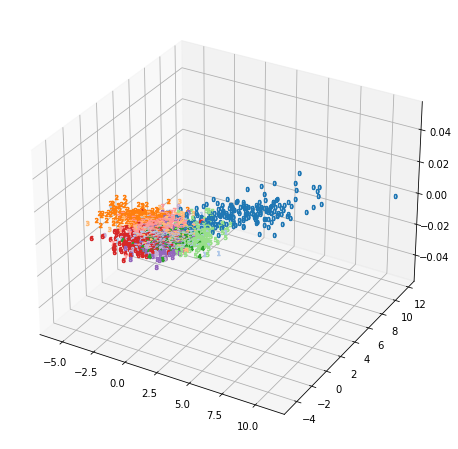

In [845]:
drawpoints_3d(X_2d_p_data,clustering_index(best_labeling))

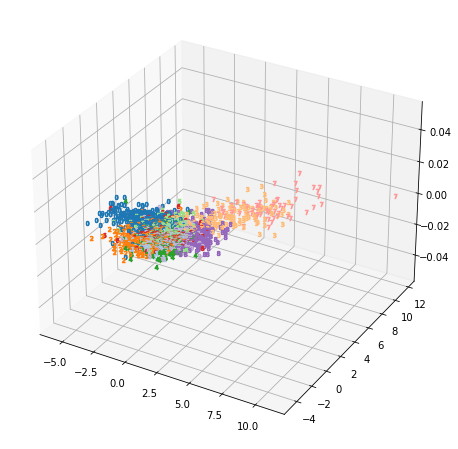

In [846]:
#kmeans_model = KMeans(n_clusters=real_cluster_number, random_state=1).fit(X_2d_p_data)
kmeans_model = KMeans(n_clusters=real_cluster_number, random_state=1).fit(normalized_observed_data)
drawpoints_3d(X_2d_p_data,kmeans_model.labels_)

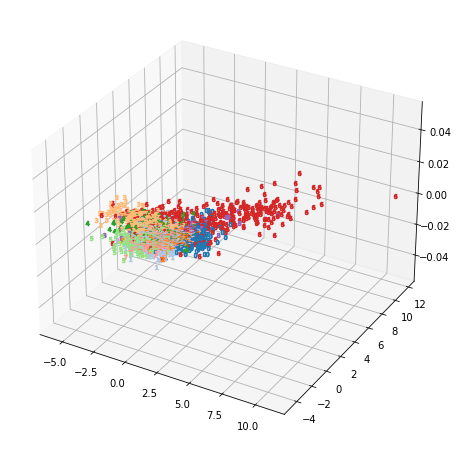

In [847]:
#gauss_model = GaussianMixture(n_components=real_cluster_number,covariance_type='full',random_state=1).fit(X_2d_p_data)
gauss_model = GaussianMixture(n_components=real_cluster_number,covariance_type='full',random_state=1).fit(normalized_observed_data)
drawpoints_3d(X_2d_p_data,gauss_model.predict(X_2d_p_data))

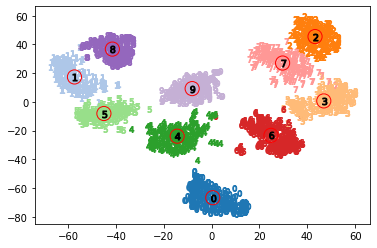

In [848]:
#points = TSNE(n_components=2,random_state=0).fit_transform(X_2d_p_data)
drawpoints_with_centers(points,clustering_index(best_labeling),best_labeling)


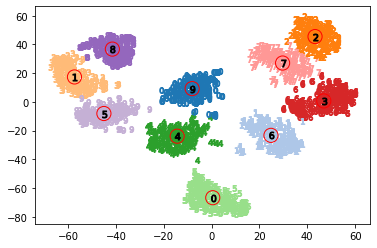

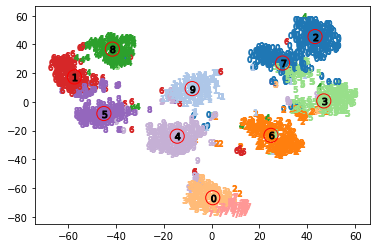

In [849]:
kmeans_model_afterTNSE = KMeans(n_clusters=real_cluster_number, random_state=1).fit(points)
drawpoints_with_centers(points,kmeans_model_afterTNSE.labels_,best_labeling)
drawpoints_with_centers(points,kmeans_model.labels_,best_labeling)

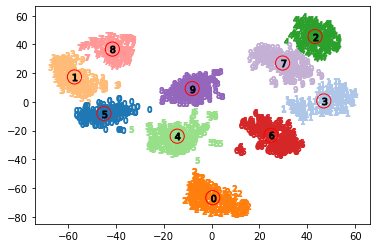

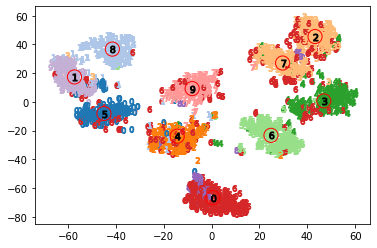

In [850]:
gauss_model_afterTNSE  = GaussianMixture(n_components=real_cluster_number,covariance_type='full',random_state=1).fit(points)
drawpoints_with_centers(points,gauss_model_afterTNSE.predict(points),best_labeling)
drawpoints_with_centers(points,gauss_model.predict(X_2d_p_data),best_labeling)

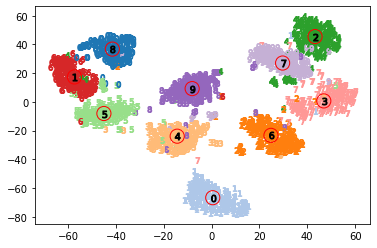

CPU times: user 21.5 s, sys: 8.33 ms, total: 21.5 s
Wall time: 21.5 s


In [851]:
%%time
drawpoints_with_centers(points,ts_p_l10,best_labeling)

In [559]:
points.shape

(1000, 2)